# Base Paper Implementation

## Preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'drop': None,  #[p for p in range(40, 400)],  #['46', '47'],
    'downsample_rate': 1,
    'rolling_lookback': [840, 6360, 3360, 1320],
    'valset': [81],
    'testset': [65, 72],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Drop specified profiles if any
if data_cfg['drop'] is not None:
    drop_p_l = [int(p) for p in data_cfg['drop']]
    dataset.drop(index=dataset[dataset['profile_id'].isin(drop_p_l)].index, inplace=True)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]

# Create time column
dataset['time'] = dataset.groupby('profile_id').cumcount() * 0.5

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookback = args
    dummy = np.zeros((lookback, len(df.columns)))
    dummy = pd.DataFrame(dummy, columns=df.columns)
    df = pd.concat([dummy, df], axis=0, ignore_index=True)
    ew_mean = pd.concat([df.ewm(span=lb).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lb)) for lb in [lookback]], axis=1)
    ew_std = pd.concat([df.ewm(span=lb).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lb)) for lb in [lookback]], axis=1)
    return pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
with multiprocessing.Pool(2) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback'][0]) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset.csv', index=False)

## Splitting the Data for training and testing

In [11]:
import pandas as pd

# Load the preprocessed dataset
dataset = pd.read_csv('processed_dataset.csv')

# Define the profile IDs for validation and testing
valset = [81]
testset = [65, 72]

# Split the dataset based on profile IDs
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Print the shapes of the split datasets
print("Training set shape:", train_profiles.shape)
print("Validation set shape:", val_profiles.shape)
print("Testing set shape:", test_profiles.shape)

# Now you can use train_profiles, val_profiles, and test_profiles DataFrames for further processing and model training

Training set shape: (1257749, 112)
Validation set shape: (17672, 112)
Testing set shape: (55395, 112)


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout, InputLayer
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping

# Custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred)))

# Load the preprocessed dataset
dataset = pd.read_csv('processed_dataset.csv')

# Define the profile IDs for validation and testing
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split the dataset based on profile IDs
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Extract features and targets
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train = train_profiles[x_cols].values
y_train = train_profiles[y_cols].values
X_val = val_profiles[x_cols].values
y_val = val_profiles[y_cols].values
X_test = test_profiles[x_cols].values
y_test = test_profiles[y_cols].values

# Reshape the data for Conv1D
lookback = 10  # Number of time steps to look back

# Ensure number of samples is a multiple of lookback
train_samples = (X_train.shape[0] // lookback) * lookback
val_samples = (X_val.shape[0] // lookback) * lookback
test_samples = (X_test.shape[0] // lookback) * lookback

# Reshape X datasets correctly
X_train = X_train[:train_samples].reshape((train_samples // lookback, lookback, len(x_cols)))
y_train = y_train[:train_samples][lookback - 1::lookback]  # Adjust target values accordingly

X_val = X_val[:val_samples].reshape((val_samples // lookback, lookback, len(x_cols)))
y_val = y_val[:val_samples][lookback - 1::lookback]

X_test = X_test[:test_samples].reshape((test_samples // lookback, lookback, len(x_cols)))
y_test = y_test[:test_samples][lookback - 1::lookback]

# Ensure dataset sizes are correct
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build the CNN model
model = Sequential([
    InputLayer(input_shape=(lookback, len(x_cols))),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(len(y_cols))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[rmse])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test RMSE: {test_rmse}')

# Save the model
model.save('cnn_time_series_model_own.h5')


X_train shape: (103338, 10, 7), y_train shape: (103338, 4)
X_val shape: (5727, 10, 7), y_val shape: (5727, 4)
X_test shape: (24016, 10, 7), y_test shape: (24016, 4)
Epoch 1/50


/home/yugendran-sunder/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3230/3230 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2495 - rmse: 0.8707 - val_loss: 0.2152 - val_rmse: 0.6542
Epoch 2/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1796 - rmse: 0.9122 - val_loss: 0.1950 - val_rmse: 0.6562
Epoch 3/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1590 - rmse: 0.9197 - val_loss: 0.1969 - val_rmse: 0.7016
Epoch 4/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1494 - rmse: 0.9243 - val_loss: 0.2056 - val_rmse: 0.5924
Epoch 5/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1422 - rmse: 0.9282 - val_loss: 0.1903 - val_rmse: 0.6795
Epoch 6/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1363 - rmse: 0.9361 - val_loss: 0.1778 - val_rmse: 0.6671
Epoch 7/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1329 - rmse: 0.9378 - val_loss: 0.1928 - val_rmse: 0.7198
Epoch 8/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1279 - rmse: 0.9387 - val_loss: 0.1753 - val_rmse: 0.6747
Epoch 9/50
3230/3230 ━━━━━━━━━━━━━━

Test Loss: 0.2348284274339676, Test RMSE: 0.763839066028595


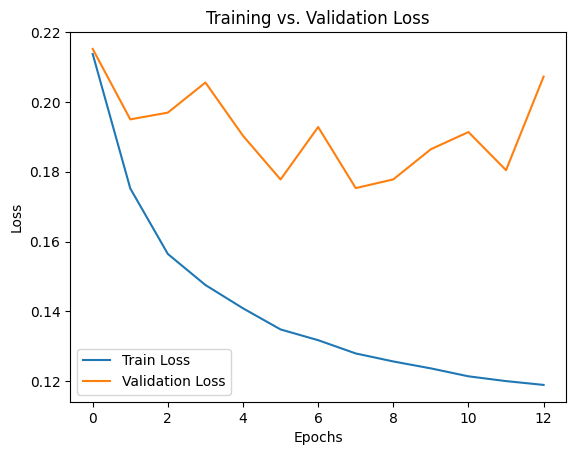

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


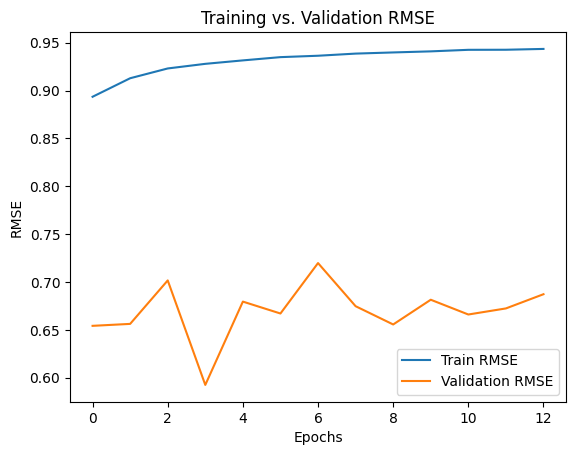

In [30]:
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs. Validation RMSE')
plt.show()


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 10, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 10, 64)    │        960 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 10, 64)    │          0 │ activation_3[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 10, 64)    │      8,256 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 10, 64)    │        512 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 10, 64)    │          0 │ activation_4[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 64)    │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 10, 64)    │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 10, 64)    │          0 │ activation_5[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_19[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 4)         │        260 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,012 (74.27 KB)

 Trainable params: 18,628 (72.77 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.2701 - rmse: 1.3984 - val_loss: 1.3552 - val_rmse: 0.5450
Epoch 2/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.2410 - rmse: 0.8791 - val_loss: 0.8973 - val_rmse: 0.5233
Epoch 3/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.4482 - rmse: 0.7398 - val_loss: 0.6848 - val_rmse: 0.5160
Epoch 4/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.0000 - rmse: 0.6467 - val_loss: 0.5757 - val_rmse: 0.5128
Epoch 5/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.7283 - rmse: 0.5792 - val_loss: 0.5171 - val_rmse: 0.5175
Epoch 6/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.5622 - rmse: 0.5347 - val_loss: 0.4755 - val_rmse: 0.5136
Epoch 7/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.4545 - rmse: 0.5019 - val_loss: 0.4285 - val_rmse: 0.4987
Epoch 8/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3845 - rmse: 0.4804 - val_loss: 0.3994 - val_rmse: 0.4910
Epoch 9/50
3230/3230 ━━

Test Loss: 0.3085, Test RMSE: 0.4714


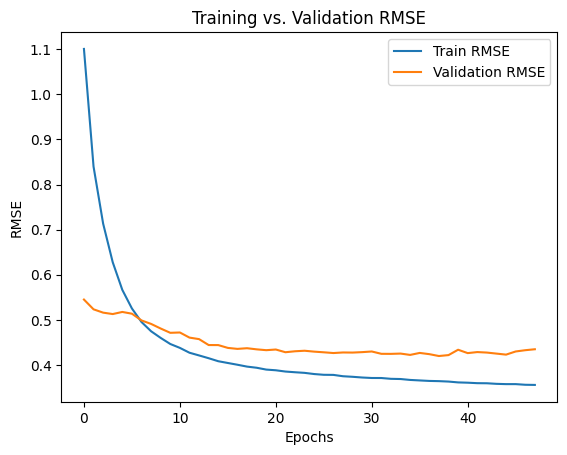

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
lookback = 10  

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

# CNN Model
def build_cnn_model(x_shape, arch='plain', n_layers=3, n_units=64, activation='relu', 
                    kernel_size=3, dilation_start_rate=1, regularization_rate=1e-4, 
                    dropout_rate=0.3, optimizer='adam', lr_rate=5e-5, loss='mse', n_outputs=4):
    assert arch in ['plain', 'res'], "Specified architecture not recognized!"

    opts_map = {
        'adam': optimizers.Adam, 'nadam': optimizers.Nadam, 
        'adamax': optimizers.Adamax, 'sgd': optimizers.SGD, 
        'rmsprop': optimizers.RMSprop
    }

    # Model Configuration
    cnn_cfg = {
        'x_shape': x_shape, 'arch': arch, 'n_filters': int(n_units), 
        'kernel_size': int(kernel_size), 'dilation_start_rate': int(dilation_start_rate), 
        'n_layers': int(n_layers), 'activation': activation, 'dropout_rate': dropout_rate, 
        'reg_rate': regularization_rate, 'batchnorm': activation != 'selu', 
        'n_outputs': n_outputs
    }

    model = cnn_network(**cnn_cfg)

    opt = opts_map[optimizer](learning_rate=lr_rate)
    model.compile(optimizer=opt, loss=loss, metrics=[rmse])
    model.summary()
    return model

# CNN Network with Residual Option
def cnn_network(x_shape, arch, n_filters, kernel_size, dilation_start_rate,
                n_layers, activation, dropout_rate=0.5, reg_rate=1e-6,
                batchnorm=True, n_outputs=4):
    
    regs = {
        'kernel_regularizer': regularizers.l2(reg_rate),
        'bias_regularizer': regularizers.l2(reg_rate),
        'activity_regularizer': regularizers.l2(reg_rate)
    }

    def add_common_layers(z):
        if batchnorm:
            z = layers.BatchNormalization()(z)
        z = layers.Activation(activation)(z)
        z = layers.Dropout(dropout_rate)(z)  
        return z

    x = layers.Input(shape=x_shape)
    y = x  

    for i in range(n_layers):
        dilation_rate = dilation_start_rate * (2 ** i)

        if i % 2 == 0 and arch == 'res':
            shortcut = y  

        y = layers.Conv1D(n_filters, kernel_size, padding='causal', 
                          dilation_rate=dilation_rate, activation=None, **regs)(y)
        y = add_common_layers(y)

        if i % 2 == 1 and arch == 'res':
            shortcut = layers.Conv1D(n_filters, kernel_size=1, padding='causal', 
                                     activation=None, **regs)(shortcut)
            y = layers.add([shortcut, y])

    y = layers.GlobalMaxPooling1D()(y)
    y = layers.Dense(n_outputs)(y)  

    model = models.Model(inputs=x, outputs=y)
    return model

# Build CNN Model
cnn_model = build_cnn_model(x_shape=(lookback, len(x_cols)), arch='res', 
                            n_layers=3, n_units=64, activation='relu', 
                            kernel_size=2, dilation_start_rate=1, 
                            regularization_rate=1e-4, dropout_rate=0.3, 
                            optimizer='adam', lr_rate=5e-5, loss='mse', 
                            n_outputs=len(y_cols))

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, restore_best_weights=True, mode='min')

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate model
test_loss, test_rmse = cnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}')

# Save model
cnn_model.save('cnn_time_series_model.h5')

# Plot RMSE over epochs
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs. Validation RMSE')
plt.show()


# RNN Implementation

Epoch 1/100


/home/yugendran-sunder/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3230/3230 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.7166 - rmse: 1.2902 - val_loss: 0.3526 - val_rmse: 0.5329
Epoch 2/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.6381 - rmse: 0.7933 - val_loss: 0.3516 - val_rmse: 0.5328
Epoch 3/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.4523 - rmse: 0.6671 - val_loss: 0.3397 - val_rmse: 0.5249
Epoch 4/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.3854 - rmse: 0.6152 - val_loss: 0.3596 - val_rmse: 0.5414
Epoch 5/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.3537 - rmse: 0.5888 - val_loss: 0.3650 - val_rmse: 0.5448
Epoch 6/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.3325 - rmse: 0.5704 - val_loss: 0.3591 - val_rmse: 0.5402
Epoch 7/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.3176 - rmse: 0.5577 - val_loss: 0.3494 - val_rmse: 0.5326
Epoch 8/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.3082 - rmse: 0.5492 - val_loss: 0.3454 - val_rmse: 0.5276
Epoch 9/100
3230/323

Test Loss: 0.20227201282978058, Test RMSE: 0.3705050051212311


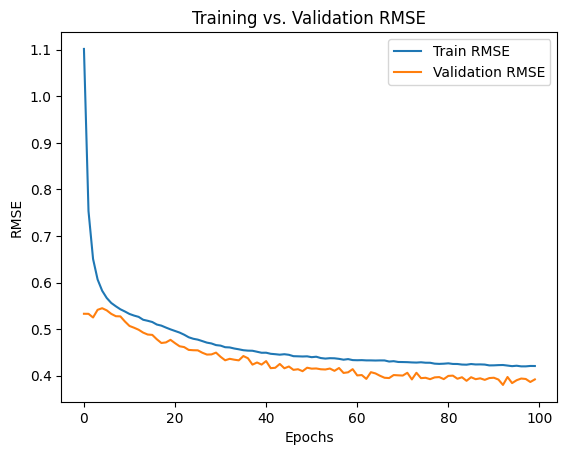

In [27]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization, InputLayer
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import regularizers

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load the dataset
dataset = pd.read_csv('processed_dataset.csv')

# Define profile IDs for validation and testing
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split the dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Extract features and targets
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train = train_profiles[x_cols].values
y_train = train_profiles[y_cols].values
X_val = val_profiles[x_cols].values
y_val = val_profiles[y_cols].values
X_test = test_profiles[x_cols].values
y_test = test_profiles[y_cols].values

# Ensure sequences match the lookback value
lookback = 10  

def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X = X[:num_samples]
    y = y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))
    y = y[lookback - 1::lookback]  # Align y to match lookback
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

# Build the improved RNN model
model = Sequential()
model.add(InputLayer(input_shape=(lookback, len(x_cols))))
model.add(GRU(64, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(1e-5)))  # L2 Regularization
model.add(Dropout(0.6))  # Increased Dropout

model.add(GRU(64, activation='relu', return_sequences=False, 
              kernel_regularizer=regularizers.l2(1e-5)))  # Another GRU Layer
model.add(Dropout(0.6))

model.add(BatchNormalization())  # Normalization to stabilize training
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.6))
model.add(Dense(len(y_cols)))  # Final output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=5e-5), loss=MeanSquaredError(), metrics=[rmse])

# Early stopping with higher patience
early_stopping = EarlyStopping(monitor='val_rmse', patience=15, restore_best_weights=True, mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test RMSE: {test_rmse}')

# Save the model
model.save('improved_rnn_model.h5')

# Plot training & validation RMSE
import matplotlib.pyplot as plt

plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs. Validation RMSE')
plt.show()


### RNN MODEL SUMMARY

In [ ]:
from keras.models import load_model
import tensorflow as tf

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load the saved model
model = load_model('improved_rnn_model.h5', custom_objects={'rmse': rmse})


# Print the model summary
model.summary()

2025-03-12 21:51:46.579557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741796506.626544    4954 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741796506.639515    4954 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741796506.738275    4954 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741796506.738294    4954 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741796506.738295    4954 computation_placer.cc:177] computation placer alr

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,138 (180.23 KB)

 Trainable params: 46,008 (179.72 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
import pandas as pd
dataset = pd.read_csv('processed_dataset.csv')

# Define profile IDs for validation and testing
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split the dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Extract features and targets
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train = train_profiles[x_cols].values
y_train = train_profiles[y_cols].values
X_val = val_profiles[x_cols].values
y_val = val_profiles[y_cols].values
X_test = test_profiles[x_cols].values
y_test = test_profiles[y_cols].values

lookback = 10  

def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X = X[:num_samples]
    y = y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))
    y = y[lookback - 1::lookback]  # Align y to match lookback
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

yhat=model.predict(X_val)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [7]:
yhat

array([[-1.0838224 , -1.0410366 , -1.1606988 , -1.1882446 ],
       [-0.18572605, -0.4444181 , -0.43175134, -0.44625273],
       [-0.5186496 , -0.63363326, -0.6456449 , -0.641184  ],
       ...,
       [ 0.38270998,  1.1031095 ,  0.72336274,  0.401533  ],
       [ 0.38236058,  1.1038604 ,  0.7239306 ,  0.40205446],
       [ 0.38299584,  1.1027238 ,  0.7230767 ,  0.4012604 ]],
      dtype=float32)

In [8]:
import numpy as np
import tensorflow as tf

def score_rnn(loss_fn, yhat, y):
    """Score function for RNN model that returns the computed loss."""
        # Convert input data to TensorFlow tensors
    x_tensor = tf.convert_to_tensor(yhat, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

    # Compute loss
    loss = np.mean(loss_fn(y_tensor, x_tensor))

    print(f'Loss: {loss:.6f} K²')
    return loss


In [9]:
loss_fn = tf.keras.losses.MeanSquaredError()
loss_value = score_rnn(loss_fn, yhat, y_val)
loss_value

Loss: 0.198807 K²


np.float32(0.19880697)